# Import des librairies

In [70]:
#Main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Embeddings

from sentence_transformers import util, SentenceTransformer

In [3]:
#deep learning

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

In [ ]:
#Classifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [58]:
#Model selection

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from IPython.display import display

# Import des données

In [4]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data.shape

(7613, 5)

In [7]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Split training data and validation data

In [8]:
train_data, val_data = train_test_split(data, test_size=0.1)

In [9]:
train_data.shape

(6851, 5)

In [10]:
val_data.shape

(762, 5)

### Resetting index

In [11]:
train_data.reset_index(drop=True, inplace=True)

In [12]:
train_data.head()

,id,keyword,location,text,target
0,6160,hijack,NaN,Swansea ?plot hijack transfer move for Southam...,0
1,6395,hurricane,New York,Bluedio Turbine Hurricane H Bluetooth 4.1 Wire...,0
2,2846,cyclone,Geneva,Blending the old with the new in #Vanuatu to p...,0
3,7644,pandemonium,NaN,http://t.co/PmHMmkSPaQ -PANDEMONIUM! Playstati...,0
4,6391,hurricane,"Haiku, Maui, Hawaii",HURRICANE GUILLERMO LIVE NOAA TRACKING / LOOPI...,1


In [13]:
val_data.reset_index(drop=True, inplace=True)

### Separating X and target

In [14]:
X_train = train_data['text']

In [15]:
y_train = train_data['target']

In [16]:
X_val = val_data['text']

In [17]:
y_val = val_data['target']

# Data Engineering

In [77]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [76]:
data.keyword.isna().sum()

61

In [78]:
data.location.isna().sum()

2533

In [ ]:
## TO DO ?

In [ ]:
l_full_text = []

for i in range(data.shape[0]):
    full_text = data['text'][i]
    if str(data['keyword'][i]) != 'nan':
        full_text += f' #{data["keyword"][i]}'
    if str(data['location'][i]) != 'nan':
        full_text += f' #{data["location"][i]}'

    l_full_text.append(full_text)

In [ ]:
data['full_text'] = pd.Series(l_full_text)

In [ ]:
data.head()

# Sentence Embeddings

In [18]:
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [19]:
embeddings = transformer.encode(X_train)

In [20]:
embeddings.shape

(6851, 768)

In [21]:
val_embeddings = transformer.encode(X_val)

# Deep Learning Model

### Convert embeddings and target to tensors

In [22]:
tensor_embeddings = tf.convert_to_tensor(embeddings)
tensor_y = tf.convert_to_tensor(y_train)

Metal device set to: Apple M1


2022-08-17 12:52:57.655319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-17 12:52:57.655436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
tensor_embeddings.shape

TensorShape([6851, 768])

In [24]:
tensor_y.shape

TensorShape([6851])

In [25]:
tensor_val_embeddings = tf.convert_to_tensor(val_embeddings)
tensor_val_y = tf.convert_to_tensor(y_val)

### Define model architecture

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

In [28]:
model = Sequential()

# Define model architecture.
model.add(Dense(1024, input_shape=(768,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,066,369
Trainable params: 1,066,369
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Training and performances visualization

In [31]:
history = model.fit(
    x=tensor_embeddings,
    y=tensor_y,
    batch_size=1,
    validation_data=(tensor_val_embeddings, tensor_val_y),
    callbacks=[learning_rate_reduction],
    epochs = 10)

2022-08-17 12:52:57.858777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-08-17 12:52:58.125491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6851/6851 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8066

2022-08-17 12:53:47.638447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6851/6851 [==============================] - 52s 7ms/step - loss: 0.5150 - accuracy: 0.8066 - val_loss: 0.5945 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 2/10
6851/6851 [==============================] - 51s 7ms/step - loss: 0.5170 - accuracy: 0.8345 - val_loss: 0.8262 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 3/10
6847/6851 [============================>.] - ETA: 0s - loss: 0.5126 - accuracy: 0.8426
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6851/6851 [==============================] - 51s 7ms/step - loss: 0.5125 - accuracy: 0.8427 - val_loss: 1.1347 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 4/10
6851/6851 [==============================] - 51s 7ms/step - loss: 0.4458 - accuracy: 0.8542 - val_loss: 1.3842 - val_accuracy: 0.8189 - lr: 5.0000e-04
Epoch 5/10
6848/6851 [============================>.] - ETA: 0s - loss: 0.4090 - accuracy: 0.8616
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6851/6851 [===========================

In [32]:
def plot_training_results(history, model_name):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    
    epochs_nb = history.params['epochs']
    
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.set_title(f'Loss history of {model_name} over {epochs_nb} epochs')
    ax_loss.set_xlabel('Number of epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax_acc.set_title(f'Accuracy history of {model_name} over {epochs_nb} epochs')
    ax_acc.set_xlabel('Number of epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

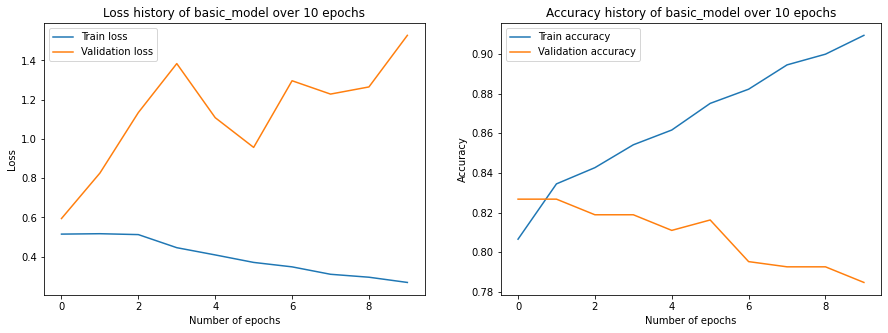

In [33]:
plot_training_results(history, 'basic_model')

In [34]:
#OVERFITTING ?

# Classifier approaches 

### RandomForestClassifier

In [39]:
rfc = RandomForestClassifier(verbose=1)

In [40]:
rfc.fit(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.3s finished


RandomForestClassifier(verbose=1)

In [41]:
rfc.score(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9976645745146694

In [42]:
rfc.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8162729658792651

### GradientBoostingClassifier

In [43]:
gbc = GradientBoostingClassifier(verbose=1)

In [44]:
gbc.fit(embeddings, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3195            2.79m
         2           1.2791            2.76m
         3           1.2445            2.73m
         4           1.2125            2.71m
         5           1.1840            2.69m
         6           1.1581            2.66m
         7           1.1333            2.63m
         8           1.1108            2.60m
         9           1.0908            2.57m
        10           1.0718            2.54m
        20           0.9367            2.26m
        30           0.8552            1.98m
        40           0.7995            1.70m
        50           0.7574            1.42m
        60           0.7226            1.14m
        70           0.6948           51.39s
        80           0.6718           34.36s
        90           0.6517           17.23s
       100           0.6336            0.00s


GradientBoostingClassifier(verbose=1)

In [45]:
gbc.score(embeddings, y_train)

0.8829367975478032

In [46]:
gbc.score(val_embeddings, y_val)

0.8280839895013123

# Hyperparameters tuning

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'n_estimators': [100, 300, 500, 1000],
               'max_depth': [300, 500, 1000]
              }

In [48]:
grid = GridSearchCV(RandomForestClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  12.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  12.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV] END ....................max_depth=300, n_estimators=300; total time=  37.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  37.3s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  37.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  37.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  36.9s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  12.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  12.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=  12.4s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  37.0s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  36.8s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  37.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  36.6s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  36.8s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=500, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=  12.3s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  37.2s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  37.2s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  37.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.8s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  36.9s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ...................max_depth=1000, n_estimators=500; total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 2.1min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.7min finished


GridSearchCV(estimator=RandomForestClassifier(verbose=1),
             param_grid={'max_depth': [300, 500, 1000],
                         'n_estimators': [100, 300, 500, 1000]},
             verbose=2)

In [49]:
grid.best_params_

{'max_depth': 500, 'n_estimators': 1000}

In [69]:
grid.best_estimator_.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.8241469816272966

In [ ]:
grid = GridSearchCV(GradientBoostingClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
      Iter       Train Loss   Remaining Time 
         1           1.1767           15.67m
         2           1.0230           13.61m
         3           0.8953           12.79m
         4           0.7877           12.48m
         5           0.6960           12.18m
         6           0.6170           11.98m
         7           0.5486           11.78m
         8           0.4890           11.28m
         9           0.4368           10.67m
        10           0.3908           10.19m
        20           0.1377            7.51m
        30           0.0530            6.09m
        40           0.0228            5.02m
        50           0.0119            4.08m
        60           0.0079            3.21m
        70           0.0064            2.38m
        80           0.0058            1.57m
        90           0.0056           46.82s
       100           0.0056            0.00s
[CV] END ....................max_depth

         1           1.1769           19.33m
         2           1.0233           19.48m
         3           0.8957           19.55m
         4           0.7882           19.67m
         5           0.6966           19.54m
         6           0.6177           19.52m
         7           0.5494           19.38m
         8           0.4898           19.26m
         9           0.4377           19.18m
        10           0.3918           19.08m
        20           0.1388           18.29m
        30           0.0543           17.81m
        40           0.0241           17.07m
        50           0.0132           16.45m
        60           0.0092           15.85m
        70           0.0077           15.19m
        80           0.0071           14.41m
        90           0.0069           13.66m
       100           0.0069           12.95m
       200           0.0068            6.10m
       300           0.0068            0.00s
[CV] END ....................max_depth=300, n_estimator

         7           0.5486           90.02m
         8           0.4890           88.05m
         9           0.4368           86.26m
        10           0.3908           85.06m
        20           0.1377           78.79m
        30           0.0530           75.90m
        40           0.0228           73.93m
        50           0.0119           72.57m
        60           0.0079           71.44m
        70           0.0064           70.46m
        80           0.0058           69.44m
        90           0.0056           68.54m
       100           0.0056           67.63m
       200           0.0055           54.55m
       300           0.0055           41.94m
       400           0.0055           34.90m
       500           0.0055           28.39m
       600           0.0055           22.56m
       700           0.0055           16.85m
       800           0.0055           11.29m
       900           0.0055            7.02m
      1000           0.0055            0.00s
[CV] END .

        50           0.0130            6.05m
        60           0.0090            4.82m
        70           0.0075            3.60m
        80           0.0070            2.39m
        90           0.0068            1.19m
       100           0.0067            0.00s
[CV] END ....................max_depth=500, n_estimators=100; total time=11.9min
      Iter       Train Loss   Remaining Time 
         1           1.1770           11.27m
         2           1.0235           11.38m
         3           0.8960           11.12m
         4           0.7885           10.94m
         5           0.6969           10.80m
         6           0.6180           12.70m
         7           0.5497           12.26m
         8           0.4902           11.94m
         9           0.4380           11.61m
        10           0.3921           11.34m
        20           0.1393            9.42m
        30           0.0548            8.03m
        40           0.0247            6.79m
        50        

        50           0.0136         1705.54m
        60           0.0096         1367.24m
        70           0.0081         1125.41m
        80           0.0076          943.87m
        90           0.0074          802.51m
       100           0.0073          689.29m
       200           0.0073          175.44m
       300           0.0073            0.00s
[CV] END ...................max_depth=500, n_estimators=300; total time=356.3min
      Iter       Train Loss   Remaining Time 
         1           1.1767           46.42m
         2           1.0230           42.20m
         3           0.8953           40.20m
         4           0.7877           39.56m
         5           0.6960           39.19m
         6           0.6170           38.66m
         7           0.5486           38.46m
         8           0.4890           38.18m
         9           0.4368           37.88m
        10           0.3908           37.81m
        20           0.1377           36.42m
        30        

        40           0.0240           72.51m
        50           0.0130           71.17m
        60           0.0090           69.93m
        70           0.0075           68.91m
        80           0.0070           67.92m
        90           0.0068           67.08m
       100           0.0067           66.22m
       200           0.0067           54.74m
       300           0.0067           44.57m
       400           0.0067           36.83m
       500           0.0067           29.84m
       600           0.0067           23.32m
       700           0.0067           17.56m
       800           0.0067           22.25m
       900           0.0067           21.55m
      1000           0.0067            0.00s
[CV] END ..................max_depth=500, n_estimators=1000; total time=377.8min
      Iter       Train Loss   Remaining Time 
         1           1.1770           70.20m
         2           1.0235           71.64m
         3           0.8960           70.63m
         4        

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)